# Neural Network

## Навигация

1. [Предобработка](#Предобработка)
1. [One-Hot Encoding модель](#One-Hot-Encoding-модель)
1. [train/val/test разбивка и конвертация из DataFame в Dataset](#train/val/test-разбивка-и-конвертация-из-DataFame-в-Dataset)
1. [Модель нейронной сети](#Модель-нейронной-сети)
1. [SHAP values](#SHAP-values)

In [1]:
RANDOM_STATE = 42

In [2]:
import os
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', None)
import shap
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.random.set_seed(RANDOM_STATE)

import src

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
DATA_PATH = os.path.join('..', 'data', 'processed', 'encoded.csv')
NEURAL_NETWORK_MODEL_PATH = os.path.join('..', 'models', 'neural network')

TRAIN_SIZE = .7
VAL_SIZE = .2

LAYER_WIDTH = 64
BATCH_SIZE = 64
NUM_EPOCHS = 300

In [4]:
def plot_history(history, *, dpi=70):
    """
    Визуализирует историю обучения.

    Args:
        history: собственно история.
        dpi: количество пикселей на дюйм.
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=dpi)
    axes[0].plot(history.history['accuracy'], label='train_accuracy')
    axes[0].plot(history.history['val_accuracy'], label='val_accuracy')
    axes[0].set(xlabel='эпохи', ylabel='accuracy')
    axes[0].legend()

    axes[1].plot(history.history['loss'], label='train_loss')
    axes[1].plot(history.history['val_loss'], label='val_loss')
    axes[1].set(xlabel='эпохи', ylabel='loss')
    axes[1].legend()

    plt.show()

In [5]:
data = pd.read_csv(DATA_PATH)
data.head()

,2. Возраст,3. Семейное положение,"4. Если имеете супруга или партнера, как долго вы живете вместе (в годах)?",5. В какой семье Вы выросли?,6. Жив ли хотя бы один из Ваших родителей (да/нет)?,"7. Если да, как часто вы общаетесь?",8. Есть ли у Вас дети (да/нет)?,"9. Если да, сколько?",10. Есть ли у Вас совершеннолетние дети (да/нет)?,"11. Если да, как часто вы общаетесь?",12. Сколько человек живут вместе с Вами?,13. Каковы Ваши взаимоотношения с соседями?,14. Как часто Вы встречаетесь с друзьями?,15. Есть ли у Вас домашние питомцы (да/нет)?,"16. В течение последних 7 дней, как часто Вы практиковали тяжелые физические нагрузки?","17. В течение последних 7 дней, как часто Вы практиковали умеренные физические нагрузки?","18. В течение последних 7 дней, как часто Вы ходили пешком минимум 10 минут без перерыва?",19. Уровень Вашего образования?,20. Каков уровень образования Вашего партнера (если применимо)?,22. Как долго Вы проживаете в этом месте (в годах)?,23. Каков тип Вашего дома?,"24. Если Вы живете в многоквартирном доме, то на каком этаже?",25. Каким транспортом Вы обычно пользуетесь?,26. Сколько времени занимает Ваш путь до работы в одну сторону?,27. Каков тип Вашей занятости?,28. Каковы Ваши предпочтения в пище?,29. Каков тип Вашего питания?,30. Вы курите (да/нет)?,31. Количество родов,32. Количество прерванных беременностей,33. Гинекологические заболевания (да/нет),34. Заболевания щитовидной железы (да/нет),35. Наследственность (да/нет),Метка
0,46.515068,имею гражданского супруга,21.0,0.0,1,1.0,1,1.0,1.0,0.0,2.0,1.0,1.0,1.0,NaN,NaN,7.0,1.0,1.0,7.0,многоквартирный дом,12.0,общественный транспорт,NaN,3.0,0.0,0.0,0.0,1,0,1,0,0,норма
1,45.983562,разведена,NaN,0.0,1,2.0,1,1.0,1.0,1.0,0.0,0.0,2.0,1.0,4.0,4.0,7.0,1.0,NaN,11.0,многоквартирный дом,5.0,общественный транспорт,1.0,0.0,1.0,2.0,0.0,1,0,1,0,0,норма
2,35.443836,замужем,11.0,0.0,1,2.0,1,1.0,0.0,NaN,2.0,1.0,1.0,1.0,1.0,3.0,7.0,2.0,2.0,34.0,многоквартирный дом,3.0,общественный транспорт,0.0,2.0,0.0,1.0,1.0,1,2,0,0,0,норма
3,53.539726,разведена,NaN,0.0,1,1.0,1,2.0,1.0,1.0,2.0,0.0,3.0,1.0,0.0,0.0,7.0,2.0,0.0,50.0,многоквартирный дом,5.0,общественный транспорт,1.0,0.0,0.0,0.0,1.0,2,5,0,0,0,норма
4,44.115068,замужем,12.0,0.0,1,1.0,1,1.0,1.0,0.0,2.0,1.0,3.0,0.0,5.0,0.0,7.0,0.0,2.0,4.0,многоквартирный дом,4.0,я обычно не пользуюсь транспортом,0.0,0.0,1.0,0.0,0.0,1,2,1,0,0,норма


## Предобработка

[Навигация](#Навигация)

Масштабируем численные признаки:
- те, что имеют нормальное (Гаусово) распределение, стандартизируем
- другие нормализуем

In [6]:
def standanrdized(df, feature_name, *, fill_nan=0):
    """Возвращает df со стандартизированным столбцом feature_name."""
    df = df.copy()
    df.loc[df[feature_name].notna(), feature_name] = (df[feature_name] - df[feature_name].mean()) / df[feature_name].std()
    df.loc[df[feature_name].isna(), feature_name] = fill_nan
    return df

In [7]:
def normalized(df, feature_name, *, fill_nan=0):
    """Возвращает df с нормализованным столбцом feature_name."""
    df = df.copy()
    df.loc[df[feature_name].notna(), feature_name] = (df[feature_name] - df[feature_name].min()) / (df[feature_name].max() - df[feature_name].min())
    df.loc[df[feature_name].isna(), feature_name] = fill_nan
    return df

In [8]:
data = standanrdized(data, src.constants.QUESTION_2)
data = normalized(data, src.constants.QUESTION_4)
data = normalized(data, src.constants.QUESTION_22)
data = normalized(data, src.constants.QUESTION_24)

Кодируем бинарные признаки.

In [9]:
for feature in src.constants.BINARY_FEATURES:
    if data[feature].isna().sum():
        data[feature].replace({np.NaN: 0}, inplace=True)
    data[feature].replace({src.constants.YES: 1, src.constants.NO: 0}, inplace=True)

## One-Hot Encoding модель

[Навигация](#Навигация)

One-Hot Encoding категориальных и ранговых признаков.

In [10]:
def make_prefix(string):
    """Выделяет из названия признака только его номер."""
    prefix = ''.join(char for char in string if char.isdigit())
    if len(prefix) > 2:
        prefix = prefix[:2]
    return prefix

In [11]:
one_hot_df = data.copy()
for feature in list(src.constants.CATEGORICAL_FEATURES) + list(src.constants.RANK_FEATURES):
    prefix = make_prefix(feature)
    one_hot_df = pd.concat([one_hot_df, pd.get_dummies(one_hot_df[feature], prefix=prefix, drop_first=True)], axis=1).drop([feature], axis=1)

Переименую также и остальные столбцы.

In [12]:
for feature in src.constants.NUMERICAL_FEATURES + list(src.constants.BINARY_FEATURES):
    prefix = make_prefix(feature)
    one_hot_df.rename(columns={feature: prefix}, inplace=True)

## train/val/test разбивка и конвертация из DataFame в Dataset

[Навигация](#Навигация)

In [13]:
X = one_hot_df.drop(columns=src.constants.TARGET).astype('float64')
y = one_hot_df[src.constants.TARGET]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=TRAIN_SIZE,
    stratify=y,
    random_state=RANDOM_STATE,
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=VAL_SIZE,
    stratify=y_train,
    random_state=RANDOM_STATE,
)

In [15]:
print(
    f'Обучающая часть содержит {y_train.shape[0]} точек данных.\n'
    f'Валидационная часть содержит {y_val.shape[0]} точек данных.\n'
    f'Тестовая часть содержит {y_test.shape[0]} точек данных.'
)

Обучающая часть содержит 332 точек данных.
Валидационная часть содержит 84 точек данных.
Тестовая часть содержит 179 точек данных.


In [16]:
true_labels = y_test

In [17]:
y_train = pd.get_dummies(y_train, prefix=src.constants.TARGET)
y_val = pd.get_dummies(y_val, prefix=src.constants.TARGET)
y_test = pd.get_dummies(y_test, prefix=src.constants.TARGET)

## Модель нейронной сети

[Навигация](#Навигация)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(LAYER_WIDTH, activation='relu', input_shape=(101,)),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(LAYER_WIDTH, activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(3, activation='softmax'),
])

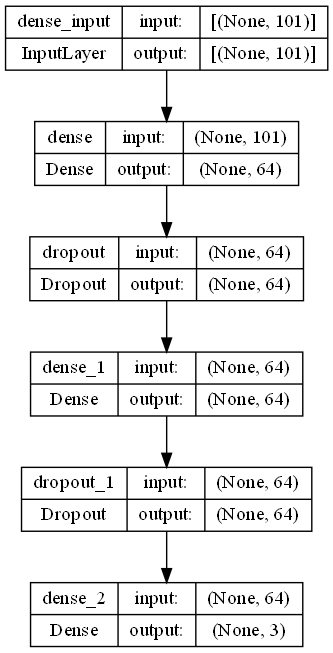

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='TB', dpi=100)

In [20]:
# Картинка встроена в jupyter notebook. Теперь удаляем файл, чтобы он не засорял проект.
os.remove('model.png')

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=NEURAL_NETWORK_MODEL_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
)
callbacks_list = [checkpoint]

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=0,
    callbacks=callbacks_list,
    validation_data=(X_val, y_val),
)

INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


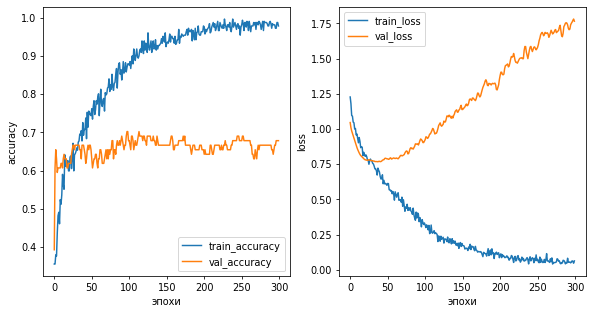

In [23]:
plot_history(history, dpi=70)

In [24]:
model = tf.keras.models.load_model(NEURAL_NETWORK_MODEL_PATH)

6/6 [==============================] - 0s 1ms/step


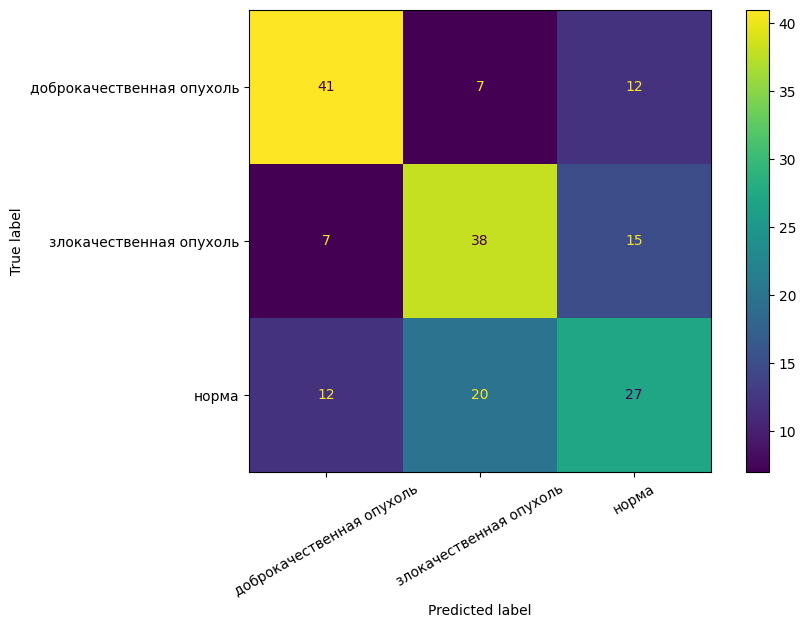

                           precision    recall  f1-score   support

доброкачественная опухоль       0.68      0.68      0.68        60
  злокачественная опухоль       0.58      0.63      0.61        60
                    норма       0.50      0.46      0.48        59

                 accuracy                           0.59       179
                macro avg       0.59      0.59      0.59       179
             weighted avg       0.59      0.59      0.59       179



In [25]:
pred_probabilities = model.predict(X_test)
pred_labels = []
for pred_probability in pred_probabilities:
    pred_label_index = np.array(pred_probability).argmax()
    pred_label = sorted(src.constants.LABELS)[pred_label_index]
    pred_labels.append(pred_label)
    
fig, ax = plt.subplots(figsize=(9, 6))
ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

print(classification_report(true_labels, pred_labels))

## SHAP values

[Навигация](#Навигация)

In [26]:
background = X_train.iloc[np.random.choice(X_train.shape[0], 100, replace=False)]

In [27]:
explainer = shap.DeepExplainer(model, background.to_numpy())
shap_values = explainer.shap_values(X.to_numpy())

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


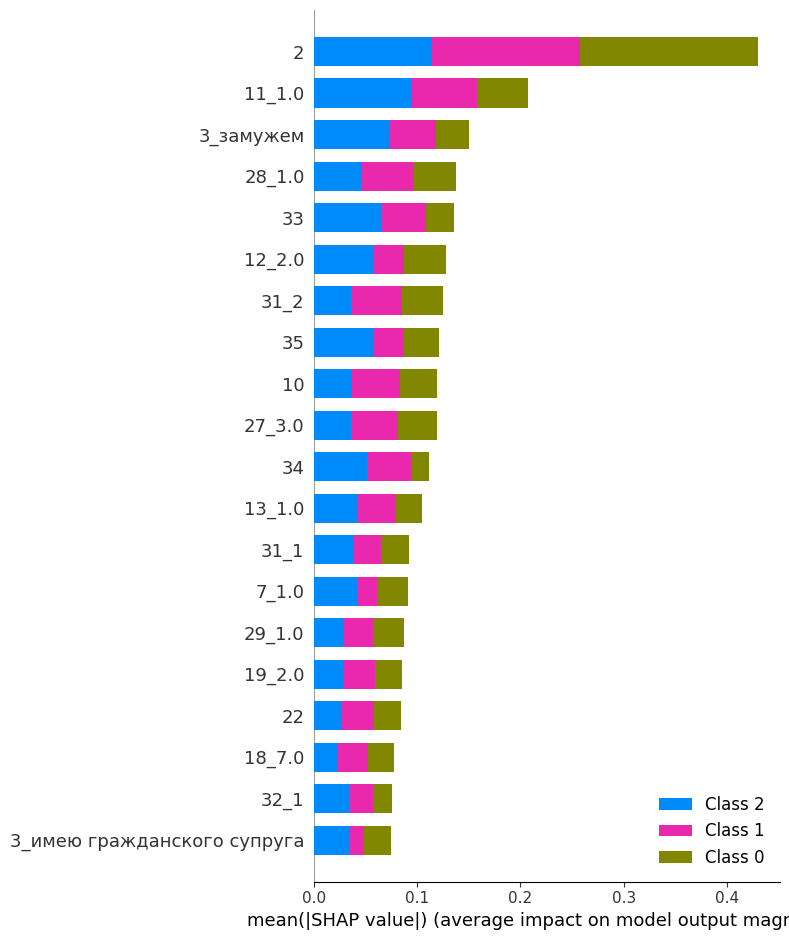

In [28]:
shap.summary_plot(shap_values, X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


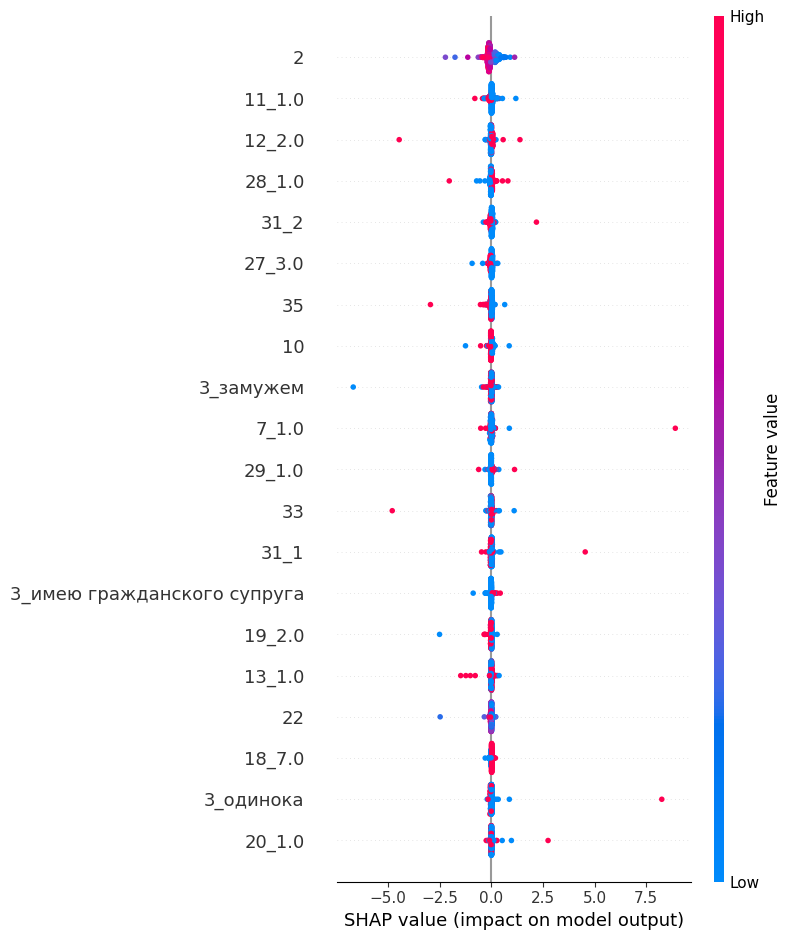

In [29]:
shap.summary_plot(shap_values[0], X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


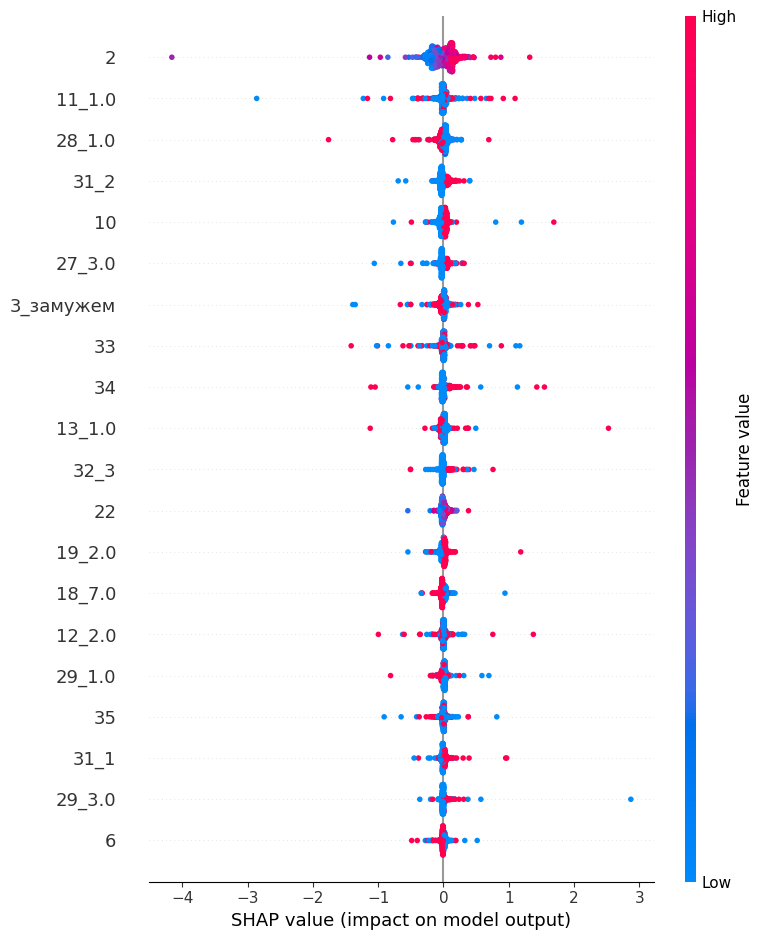

In [30]:
shap.summary_plot(shap_values[1], X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


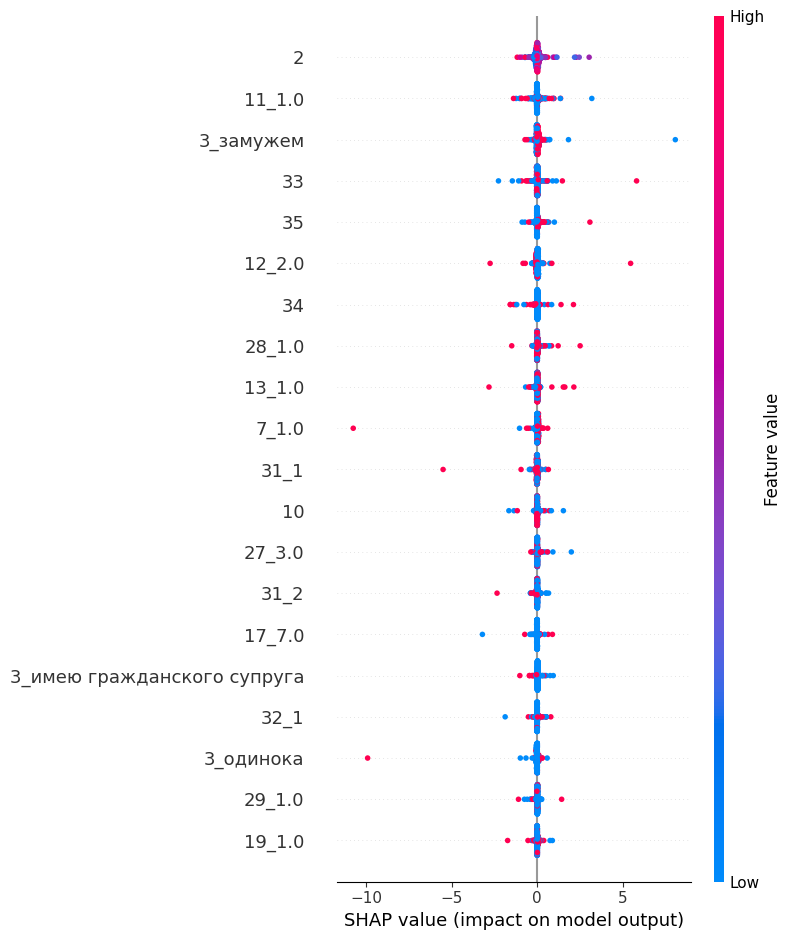

In [31]:
shap.summary_plot(shap_values[2], X)